## Autoencoder for extreme rare-event classification

- **資料集:** https://arxiv.org/abs/1809.10717

### 前言:
#### **1. 混淆矩陣(Confusion matrix): 用來評估模型的表現(performance)**

二元分類(the binary classification)的混淆矩陣(Confusion matrix):

| |  **預測為正(Scored Positive)**  |  **預測為負(Scored Negative)**  |  
|------|:------:|:------:| 
|**實際為正(Actual Positive)**|True Positive (TP)|False Negative (FN)<br>Type II Error|
|**實際為負(Actual Negative)**|False Positive (FP)<br>Type I Error|True Negative (TN)|   

- True Positive(TP): 正標籤且被正確的歸類為正標籤

- True Negative(TN): 負標籤且被正確的歸類為負標籤

- False Positive(FP): 負標籤但被不正確的歸類為正標籤

- False Negative(FN): 正標籤但被不正確的歸類為負標籤

[註] 標籤(labels)標示的慣例: 1 代表正標籤，0 代表負標籤。

#### **2. 由混淆矩陣(Confusion matrix)衍生出的評估指標**

常用的指標:

- **正確率(Accuracy):** (正 + 負)標籤正確被歸類的比率

$$ Accuracy = \frac{TP+TN}{TP+FP+TN+FN} $$

- **精確率(Precision)、Positive Predictive Value (PPV):** 預測是正標籤的情形下，實際為正標籤的比率

$$ Precision、PPV = \frac{TP}{TP + FP} $$

- **召回率(Recall)、True Positive Rate (TPR)、靈敏度(Sensitivity):** 實際是正標籤的情形下，預測為正標籤的比率 

$$ Recall、TPR、Sensitivity = \frac{TP}{TP + FN} $$

- **F1 score/measure:** 精確率(Precision)和召回率(Recall)在模型中占相同重要性的評估指標

$$ F1 = 2 \cdot  \frac{Precision \cdot  Recall}{Precision + Recall} $$

[註] F measure:

$$ F_{\beta} = (1 + \beta^{2}) \cdot \frac{Precision \cdot  Recall}{(\beta^{2}\cdot Precision) + Recall} $$

(1)當 $\beta = 0$, F measure = Precision
    
(2)當 $\beta = 1$, F measure = F1 score/measure
    
(3)當 $\beta \rightarrow \infty$, F measure = Recall
    
其他指標:

- False Negative Rate (FNR): $ FNR = \frac{FN}{TP + FN} $
 
 
- False Positive Rate (FPR): $ FPR = \frac{FP}{FP + TN} $


- True Negative Rate (TNR)、特異度(Specificity): $ TNR、Specificity = \frac{TN}{FP + TN} $


- False Discovery Rate (FDR): $ FDR = \frac{FP}{TP + FP} $


- False Omission Rate (FOR): $ FOR = \frac{FN}{FN + TN} $


- Negative Predictive Value (NPV): $ NPV = \frac{TN}{FN + TN}$


- 盛行率(Prevalence): $ Prevalence = \frac{TP + FN}{TP+FP+TN+FN}$


#### **3. ROC curve (Receiver Operating Characteristic curve) and AUC (Area Under the Curve of ROC):**

<img src="img/ROC_AUC.JPG" alt="drawing" width="360px"/>

### 實際操作

#### 一、匯入模組

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc, roc_curve

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

Using TensorFlow backend.


#### 二、資料預處理(Data preprocessing)

1.匯入資料

In [2]:
df = pd.read_excel("processminer-rare-event-mts.xlsx")

2.移動資料

- 將資料含有 y=1 的欄位向前移動兩列(row n -> n-2)作為事前預測，並將列 n-2、n-1 的 y 值設為 1 
- 去除原始資料裡 y=1 的資料， y=0 的資料當作訓練資料

In [3]:
sign = lambda x: (1, -1)[x < 0]    

def curve_shift(df, shift):
    
    col_label = 'y'
    
    # copy y column to vector
    vector = df[col_label].copy()
    
    for s in range(abs(shift)):
        tmp = vector.shift(sign(shift))
        tmp = tmp.fillna(0)
        vector += tmp
    
    # Add vector to the df (loc: 要插入欄位的 index)
    df.insert(loc = 2, column = 'y_tmp', value = vector)
    
    # Remove the rows with col_label == 1.
    df = df.drop(df[df[col_label] == 1].index)
    
    # Drop col_label and rename the y_tmp col as col_label
    df = df.drop(col_label, axis = 1)
    df = df.rename(columns={'y_tmp': col_label})
    
    # Make the col_label binary
    df.loc[df[col_label] > 0, col_label] = 1

    return df

3.顯示 y 欄位資料移動前後的差異

In [4]:
print('顯示 y 欄位移動前的資料:')
display(df.iloc[256:262, :5])
print('------------------------')
print('顯示 y 欄位移動後的資料:')
df = curve_shift(df, -2)
display(df.iloc[256:262, :5])

顯示 y 欄位移動前的資料:


,time,y,x1,x2,x3
256,1999-05-01 08:32:00,0,1.016235,-4.058394,-1.097158
257,1999-05-01 08:34:00,0,1.005602,-3.876199,-1.074373
258,1999-05-01 08:36:00,0,0.933933,-3.868467,-1.249954
259,1999-05-01 08:38:00,1,0.892311,-13.332664,-10.006578
260,1999-05-01 10:50:00,0,0.020062,-3.987897,-1.248529
261,1999-05-01 10:52:00,0,-0.109346,-5.071100,-2.409911


------------------------
顯示 y 欄位移動後的資料:


,time,y,x1,x2,x3
256,1999-05-01 08:32:00,0.0,1.016235,-4.058394,-1.097158
257,1999-05-01 08:34:00,1.0,1.005602,-3.876199,-1.074373
258,1999-05-01 08:36:00,1.0,0.933933,-3.868467,-1.249954
260,1999-05-01 10:50:00,0.0,0.020062,-3.987897,-1.248529
261,1999-05-01 10:52:00,0.0,-0.109346,-5.071100,-2.409911
262,1999-05-01 10:54:00,0.0,-0.098179,-4.070966,-3.268804


4.去除 time, x28, x61 等三個欄位

In [5]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis = 1)
df.iloc[256:262, :5]

,y,x1,x2,x3,x4
256,0.0,1.016235,-4.058394,-1.097158,2.327307
257,1.0,1.005602,-3.876199,-1.074373,0.844397
258,1.0,0.933933,-3.868467,-1.249954,2.875311
260,0.0,0.020062,-3.987897,-1.248529,-72.927591
261,0.0,-0.109346,-5.071100,-2.409911,-68.501153
262,0.0,-0.098179,-4.070966,-3.268804,-70.437784


5.將原始資料分成訓練、驗證和測試資料 (train, valid, and test datasets)

In [6]:
#from sklearn.model_selection import train_test_split

# Randomly select the data points
seed = 111 
data_split = 0.2

df_train, df_test = train_test_split(df, test_size = data_split, random_state = seed)

df_train, df_valid = train_test_split(df_train, test_size = data_split, random_state = seed)

# 訓練資料中，y = 0 的 data (x & y)
df_train_0 = df_train.loc[df['y'] == 0]

# 訓練資料中，y = 1 的 data (x & y)
df_train_1 = df_train.loc[df['y'] == 1]

# 訓練資料中，y = 0 的 data (x)
df_train_0_x = df_train_0.drop(['y'], axis = 1)

# 訓練資料中，y = 1 的 data (x)
df_train_1_x = df_train_1.drop(['y'], axis = 1)

# 驗證資料中，y = 0 的 data (x & y)
df_valid_0 = df_valid.loc[df['y'] == 0]

# 驗證資料中，y = 1 的 data (x & y)
df_valid_1 = df_valid.loc[df['y'] == 1]

# 驗證資料中，y = 0 的 data (x)
df_valid_0_x = df_valid_0.drop(['y'], axis = 1)

# 驗證資料中，y = 1 的 data (x)
df_valid_1_x = df_valid_1.drop(['y'], axis = 1)

# 測試資料中，y = 0 的 data (x & y)
df_test_0 = df_test.loc[df['y'] == 0]

# 測試資料中，y = 1 的 data (x & y)
df_test_1 = df_test.loc[df['y'] == 1]

# 測試資料中，y = 0 的 data (x)
df_test_0_x = df_test_0.drop(['y'], axis = 1)

# 測試資料中，y = 1 的 data (x)
df_test_1_x = df_test_1.drop(['y'], axis = 1)

6.資料標準化 (Standardization): 資料轉換成 Gaussian 分佈 (mean = 0, variance = 1)

In [7]:
#from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df_train_0_x)

df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)

df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)

#### 三、建立 Autoencoder Classifier

In [8]:
# 匯入所需的模組
#from keras.models import Sequential
#from keras.layers import Dense
#from keras import regularizers

# 建立線性堆疊模型(骨架)
autoencoder = Sequential()

# 參數設定
input_layer_dim = df_train_0_x_rescaled.shape[1]
encoding_dim = 32 
hidden_dim = int(encoding_dim / 2)
decoding_dim = 16
learning_rate = 1e-3

# 建立 encoder
autoencoder.add(Dense(units = encoding_dim, input_dim = input_layer_dim,
                      activity_regularizer = regularizers.l1(learning_rate), 
                      activation = 'tanh', name = 'encoder'))

autoencoder.add(Dense(units = hidden_dim, activation = 'relu', name = 'hidden_layer'))

# 建立 decoder
autoencoder.add(Dense(units = decoding_dim, activation = 'tanh', name = 'decoder'))

# 建立 output layer
autoencoder.add(Dense(units = input_layer_dim, activation = 'relu', name = 'output_layer'))

# 查看模型摘要
print(autoencoder.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, 32)                1920      
_________________________________________________________________
hidden_layer (Dense)         (None, 16)                528       
_________________________________________________________________
decoder (Dense)              (None, 16)                272       
_________________________________________________________________
output_layer (Dense)         (None, 59)                1003      
Total params: 3,723
Trainable params: 3,723
Non-trainable params: 0
_________________________________________________________________
None


#### 四、執行類神經網路訓練

In [9]:
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

train_history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled, 
                                validation_data = (df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                                epochs = 100, batch_size = 128, shuffle = True, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Train on 11533 samples, validate on 2884 samples
Epoch 1/100
 - 0s - loss: 2.8317 - acc: 0.0476 - val_loss: 2.3439 - val_acc: 0.0718
Epoch 2/100
 - 0s - loss: 1.9772 - acc: 0.0598 - val_loss: 1.6761 - val_acc: 0.0503
Epoch 3/100
 - 0s - loss: 1.4442 - acc: 0.0669 - val_loss: 1.2854 - val_acc: 0.0784
Epoch 4/100
 - 0s - loss: 1.1758 - acc: 0.0908 - val_loss: 1.1140 - val_acc: 0.0843
Epoch 5/100
 - 0s - loss: 1.0476 - acc: 0.1082 - val_loss: 1.0258 - val_acc: 0.1127
Epoch 6/100
 - 0s - loss: 0.9752 - acc: 0.1438 - val_loss: 0.9668 - val_acc: 0.1456
Epoch 7/100
 - 0s - loss: 0.9266 - acc: 0.1677 - val_loss: 0.9264 - val_acc: 0.1581
Epoch 8/100
 - 0s - loss: 0.8867 - acc: 0.1924 - val_loss: 0.8951 - val_acc: 0.1938
Epoch 9/100
 - 0s - loss: 0.8533 - acc: 0.2218 - val_loss: 0.8585 - val_acc: 0.2219
Epoch 10/100
 - 0s - loss: 0.8266 - acc: 0.2378 - val_loss: 0.8389 - val_acc: 0.2410
Epoch 11/100
 - 0s - loss: 0.8062 - acc: 0.2566 - val_loss: 0.

Epoch 94/100
 - 0s - loss: 0.6637 - acc: 0.5034 - val_loss: 0.6766 - val_acc: 0.4875
Epoch 95/100
 - 0s - loss: 0.6633 - acc: 0.5048 - val_loss: 0.6790 - val_acc: 0.5107
Epoch 96/100
 - 0s - loss: 0.6657 - acc: 0.5026 - val_loss: 0.6760 - val_acc: 0.5028
Epoch 97/100
 - 0s - loss: 0.6633 - acc: 0.5057 - val_loss: 0.6719 - val_acc: 0.5246
Epoch 98/100
 - 0s - loss: 0.6608 - acc: 0.5130 - val_loss: 0.6743 - val_acc: 0.4945
Epoch 99/100
 - 0s - loss: 0.6640 - acc: 0.5074 - val_loss: 0.6758 - val_acc: 0.5149
Epoch 100/100
 - 0s - loss: 0.6652 - acc: 0.5076 - val_loss: 0.6739 - val_acc: 0.5031


#### 五、圖形顯示訓練過程

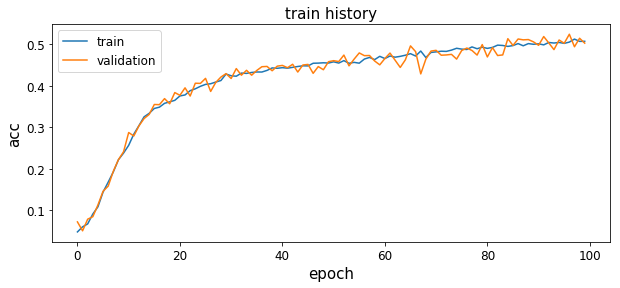

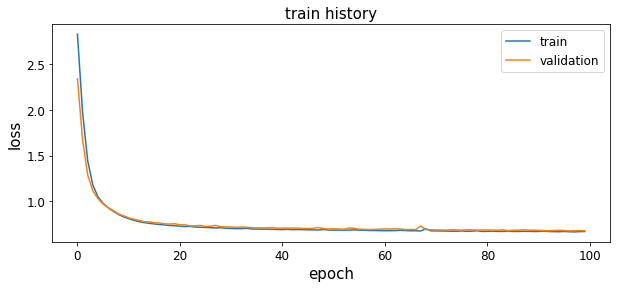

In [10]:
def show_train_history(train_history, train, validation):
    fig, ax = plt.subplots(figsize = (10, 4))
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('train history', fontsize = 15)
    plt.xlabel('epoch', fontsize = 15)
    plt.ylabel(train, fontsize = 15)
    ax.tick_params(axis = 'both', labelsize = 12)
    plt.legend(['train', 'validation'], fontsize = 12)
    plt.show()
    
# loss function 的變化    
show_train_history(train_history, 'acc', 'val_acc')

# accuracy 的變化
show_train_history(train_history, 'loss', 'val_loss')

#### 六、使用驗證資料辨認 threshold

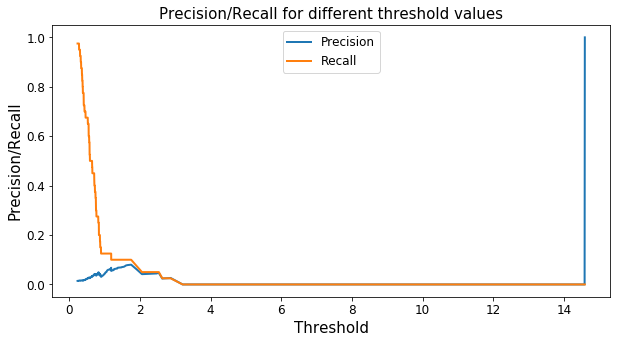

In [11]:
#from sklearn.metrics import confusion_matrix, precision_recall_curve

valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)

mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis = 1)

error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(threshold_rt, precision_rt[1:], label = "Precision", linewidth = 2)
plt.plot(threshold_rt, recall_rt[1:], label = "Recall", linewidth = 2)
plt.title('Precision/Recall for different threshold values', fontsize = 15)
plt.xlabel('Threshold', fontsize = 15)
plt.ylabel('Precision/Recall', fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 12)
plt.legend(fontsize = 12)
plt.show()

#### 七、使用測試資料進行分類

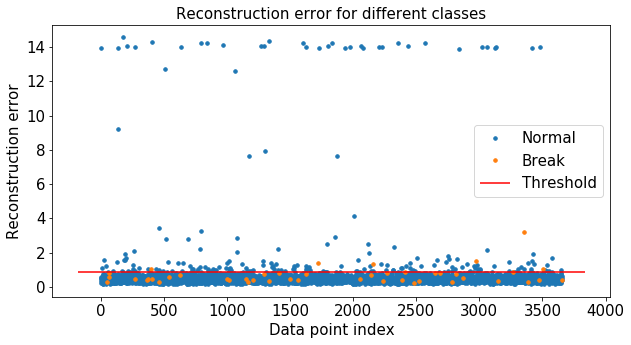

In [12]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)

mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis = 1)

error_df_test = pd.DataFrame({'Reconstruction_error': mse, 'True_class': df_test['y']})

error_df_test = error_df_test.reset_index()

threshold_fixed = 0.85

groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots(figsize = (10, 5))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker = 'o', ms = 3.5, linestyle = '',
            label = "Break" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors = "r",
          zorder = 100, label = 'Threshold')

plt.title("Reconstruction error for different classes", fontsize = 15)
plt.ylabel("Reconstruction error", fontsize = 15)
plt.xlabel("Data point index", fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 15)
ax.legend(fontsize = 15)
plt.show()

#### 八、顯示混淆矩陣(confusion matrix)

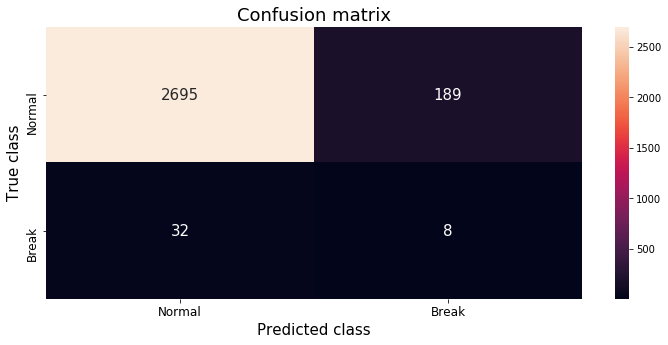

In [13]:
#import seaborn as sns
LABELS = ["Normal","Break"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

fig, ax = plt.subplots(figsize = (12, 5))
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, fmt = "d",
            annot = True, annot_kws={"size": 15});

plt.title("Confusion matrix", fontsize = 18)
plt.ylabel('True class', fontsize = 15)
plt.xlabel('Predicted class', fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

#### 九、顯示 AUC 和  ROC 曲線

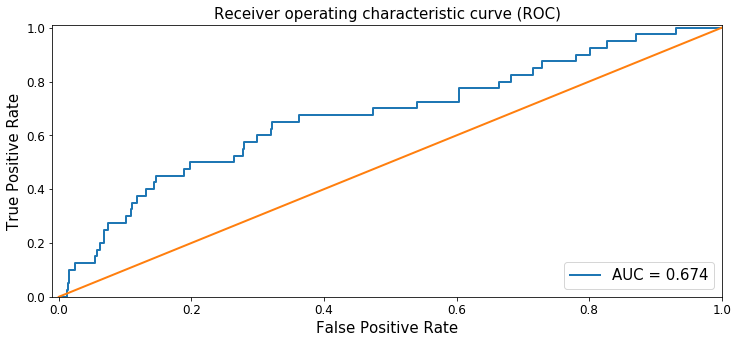

In [14]:
#from sklearn.metrics import auc, roc_curve

false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, 
                                                      error_df.Reconstruction_error)

roc_auc = auc(false_pos_rate, true_pos_rate,)

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(false_pos_rate, true_pos_rate, linewidth = 2, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth = 2)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc = 'lower right', fontsize = 15)
plt.title('Receiver operating characteristic curve (ROC)', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

#### Reference: 
- [Dataset: Rare Event Classification in Multivariate Time Series](https://arxiv.org/abs/1809.10717)



- [Extreme Rare Event Classification using Autoencoders in Keras](https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098)



- Github repo: https://github.com/cran2367/autoencoder_classifier